In [1]:
import numpy as np
import pandas as pd
import cv2
from matplotlib import pyplot as plt
from keras.models import model_from_json
%matplotlib inline

/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
def extractText(path='./Samples/5.jpeg'):
    image = cv2.imread(path)
    orig = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    plt.imshow(gray, cmap='gray')
    plt.show()
    
    # _, gray = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY)
    gray = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 9, 5)

    blurred = cv2.GaussianBlur(image, (5,5), 0)
    edged = cv2.Canny(blurred, 10, 75)
    orig_edged = edged.copy()
    plt.imshow(edged, cmap='gray')
    plt.show()

    img, contours, hierarchy = cv2.findContours(edged, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    x,y,w,h = cv2.boundingRect(contours[0])
    cv2.rectangle(image, (x,y), (x+w,y+h), (0,0,255), 2)

    for c in contours:
        p = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.1 * p, True)
        if len(approx) == 4:
            target = approx
            break

    cv2.drawContours(image, [target], -1, (255, 0, 0), 2)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

#     plt.imshow(gray[y:y+h, x:x+w], cmap='gray')
#     plt.show()
    
    return gray[y:y+h, x:x+w]

In [3]:
def processText(function):
    img, contours, hierarchy = cv2.findContours(function, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    cv2.drawContours(function, [contours[0]], 0, (255), 10)

    _, function = cv2.threshold(function, 150, 255, cv2.THRESH_BINARY_INV)
    kernel = np.ones((1,2), np.uint8)
    function = cv2.erode(function, kernel, iterations = 1)
    function = cv2.dilate(function, kernel, iterations = 1)

    kernel = np.ones((2,1), np.uint8)
    function = cv2.erode(function, kernel, iterations = 1)
    function = cv2.dilate(function, kernel, iterations = 1)

    kernel = np.ones((2,2), np.uint8)
    # function = cv2.erode(function, kernel, iterations = 1)
    function = cv2.dilate(function, kernel, iterations = 1)
    
    function = cv2.dilate(function, kernel, iterations = 2)
    function = cv2.erode(function, kernel, iterations = 1)

    function -= 255
    plt.imshow(function, cmap='gray')
    plt.show()
    return function

In [4]:
def extractCharacters(function):
    img, contours, hierarchy = cv2.findContours(function, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    contours = contours[1:]
    LEFTS = []
    RIGHTS = []
    CHARS = []

    for contour in contours:
        x,y,w,h = cv2.boundingRect(contour)

        flag = 1
        if w < 32 and h < 32:
            flag = 0

        for ix in range(len(LEFTS)):
            if x>LEFTS[ix] and x+w < RIGHTS[ix] and flag is 1:
                flag = 0

        if flag is 0:
            continue

        LEFTS.append(x)
        RIGHTS.append(x+w)

        char = function[y:y+h, x:x+w]
        # plt.imshow(char, cmap='gray')
        # plt.show()

        if w<h:
            normalized_char = np.ones((h, h), dtype='uint8')
            start = (h-w)/2
            normalized_char[:, start:start+w] = char
        else:
            normalized_char = np.ones((w, w), dtype='uint8')
            start = (w-h)/2
            normalized_char[start:start+h, :] = char

        normalized_char = cv2.resize(normalized_char, (32,32))
        CHARS.append(normalized_char)

    pairs = []
    for ix in range(len(LEFTS)):
        pairs.append((LEFTS[ix], CHARS[ix]))

    CHARACTERS = []
    pairs = sorted(pairs, key=lambda x:x[0])
    for ix in pairs:
        CHARACTERS.append(ix[1])
        # print ix[0]        
        # plt.imshow(ix[1], cmap='gray')
        # plt.show()
    return CHARACTERS

In [5]:
def extractCharactersNew(function):
    img, contours, hierarchy = cv2.findContours(function, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours = sorted(contours, key=cv2.contourArea, reverse=True)

    contours = contours[1:]
    LEFTS = []
    RIGHTS = []
    CHARS = []

    for ix in range(len(contours)):
        x,y,w,h = cv2.boundingRect(contours[ix])
        
        char = function[y:y+h, x:x+w]
        # plt.imshow(char, cmap='gray')
        # plt.show()
        
        flag = 1
        if w < 32 and h < 32:
            flag = 0

        tempflag = 0
        for px in range(len(LEFTS)):
            if (x>=LEFTS[px]-3) and ((x+w)<=RIGHTS[px]+3):
                tempflag = 1
                flag = 0
                if w<5 or h<5:
                    break
                for kx in range(len(contours[:ix])):
                    xx,yy,ww,hh = cv2.boundingRect(contours[kx])
                    if xx == LEFTS[px] and xx+ww == RIGHTS[px]:
                        if yy-(y+h) <= hh/2 and y+h<=yy and h>hh/10:
                            del LEFTS[px]
                            del RIGHTS[px]
                            del CHARS[px]
                            flag = 1
                            x = xx
                            w = ww
                            y = y
                            h = hh+yy-y
                            plt.imshow(function[y:y+h, x:x+w], cmap='gray')
                            plt.show()
                            print 'complete figure'
                                
                        break
            
            if tempflag is 1:
                break
            
        if flag is 0:
            continue

        LEFTS.append(x)
        RIGHTS.append(x+w)

        char = function[y:y+h, x:x+w]
        # plt.imshow(char, cmap='gray')
        # plt.show()

        if w<h:
            normalized_char = np.ones((h, h), dtype='uint8')
            start = (h-w)/2
            normalized_char[:, start:start+w] = char
        else:
            normalized_char = np.ones((w, w), dtype='uint8')
            start = (w-h)/2
            normalized_char[start:start+h, :] = char

        normalized_char = cv2.resize(normalized_char, (32,32))
        CHARS.append(normalized_char)

    pairs = []
    for ix in range(len(LEFTS)):
        pairs.append((LEFTS[ix], CHARS[ix]))

    CHARACTERS = []
    pairs = sorted(pairs, key=lambda x:x[0])
    for ix in pairs:
        CHARACTERS.append(ix[1])
        # print ix[0]        
        # plt.imshow(ix[1], cmap='gray')
        # plt.show()
    return CHARACTERS

In [6]:
def load_model():
    json_file = open('./Model/model.json', 'r')
    # json_file = open('./Extra Data/Old-Model/model.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights("./Model/model.h5")
    # loaded_model.load_weights("./Extra Data/Old-Model/model.h5")
    loaded_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return loaded_model

def recogniseText(characters):
    
    REV_DICT = {}
    # labels = ['+', 'c', '8', 'l', 't', 'q', '0', 'p', 'times', 'x', 'm', 'z',  '-', 'g', '5', 'k', 'pi', 'y', '4', 'f', ')', '3', 'j', 'w', '6', 'a', 'h', 'b', 'r', 'i', 'd', 'n', '9', 'v', '7', 'o', '2', 's', '(', 'forward_slash', 'e', 'u', '1']
    
    labels = ['+', 'c', '8', 'l', 't', '0', 'x', '-', 'g', '5', 'h', '4', ')', '3', '6', 'a', 'i', 'n', '9', '7', '2', 's', '(', 'sum', 'e', '1', 'o']
    labels.sort()
    for ix in range(len(labels)):
        REV_DICT[ix] = labels[ix]

    X = np.asarray(characters)
    X = X.reshape((len(characters), 32, 32, 1))
    
    model = load_model()
    score = model.predict(X, verbose=0)
    string = ''
    
    for ix in range(len(X)):
        plt.imshow(X[ix].reshape((32,32)), cmap='gray')
        plt.show()
        print REV_DICT[np.argmax(score[ix])]
        string += REV_DICT[np.argmax(score[ix])]
        
    return string

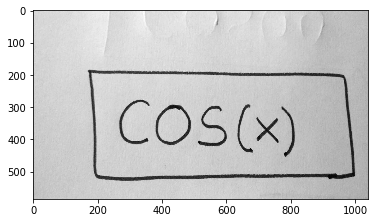

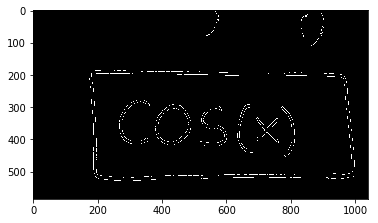

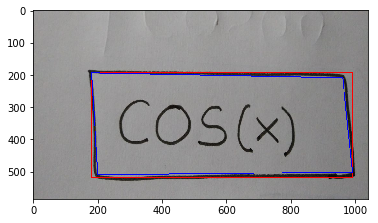

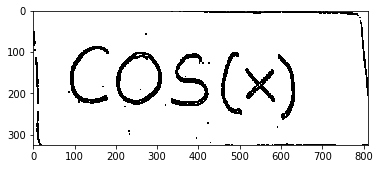

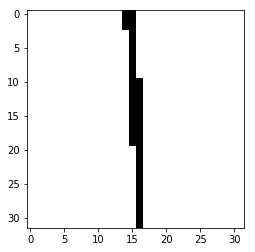

1


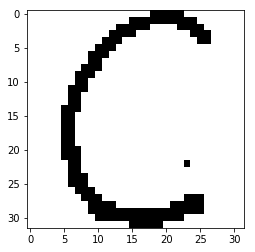

c


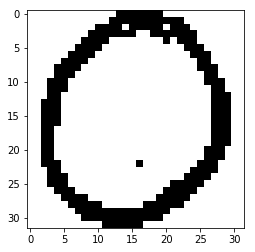

0


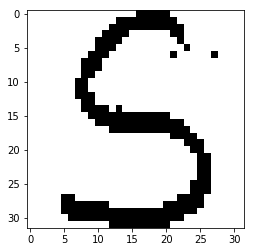

s


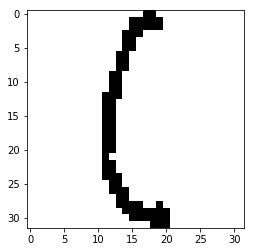

(


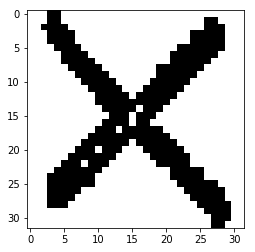

x


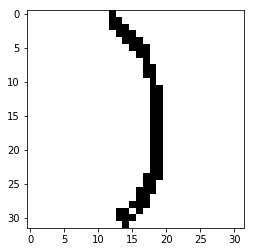

)
1c0s(x)


In [7]:
text = extractText('./Samples/2.jpeg')
text = processText(text)
characters = extractCharactersNew(text)
string = recogniseText(characters)
print string